In [1]:
import os
%matplotlib inline
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import geoviews as gv
import fiona

# 2014 General Election Data Cleaning
This notebook cleans, manipulates, and preprocesses 2018 Election Data provided by [Elections Ontario](https://www.elections.on.ca/en.html) for Analysis and Geoplotting.
## Ontario Shapefile to Geopandas Dataframe

INFO:Fiona:Failed to auto identify EPSG: 7


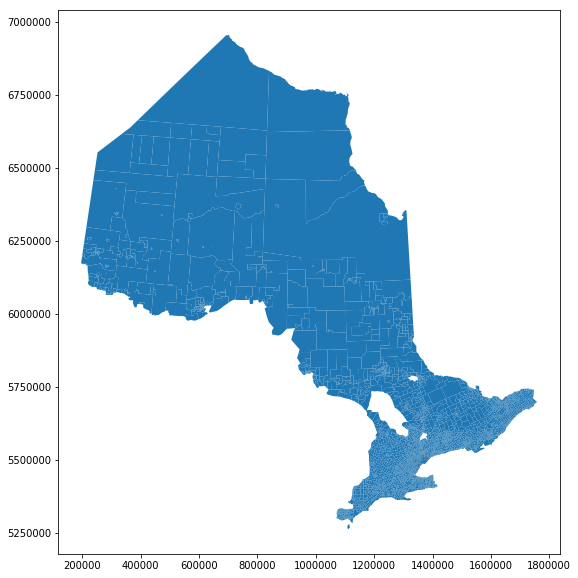

In [2]:
shp_file = './Ontario/Polling Division Shapefile - 2014 General Election'
Ontario = gpd.read_file(shp_file)
Ontario.plot(figsize=(10, 10))

There are many columns we do not need. Below drop them and keep

* **RidingID** - Unique ID number for each Riding Prevously kept in ED_ID column
* **Riding**- English name of the Riding
* **PollID** - Each Riding is made up of many polling districts at this stage this is also the ID column for each individual geometry.
* **geometry** - This is the column containing the shape of the polling districts

This dataframe is useful for a poll by poll breakdown of Election results.

In [24]:
dist = Ontario[['ED_ID',
                'KPI04',
                'POLL_DIVIS',
                'MAP_SCALE',
                'geometry']].rename(columns = {'ED_ID': 'RidingID',
                                               'KPI04': 'Riding',
                                               'POLL_DIVIS': 'PollID'})
dist['Riding'] = dist.Riding.astype('str').str.replace('', '-').str.title()
dist['RidingID'] = dist.RidingID.astype('int64')
dist['PollID'] = dist.PollID.astype('int64')

In [25]:
dist.head()

,RidingID,Riding,PollID,MAP_SCALE,geometry
0,45,London West,5,2000.0,"POLYGON ((1220582.845 5409418.132, 1220618.475..."
1,79,Sault Ste. Marie,158,2300.0,"POLYGON ((976858.763 5797022.761, 976858.93999..."
2,107,York West,435,1300.0,"POLYGON ((1361717.979 5502091.8, 1361709.071 5..."
3,65,Ottawa-Vanier,442,1000.0,"POLYGON ((1649128.695 5711832.407, 1649192.99 ..."
4,65,Ottawa-Vanier,443,600.0,"POLYGON ((1648755.028 5712217.394, 1648770.206..."


To get the Ridings which each seat represents we must dissolve each electoral district into its Riding by RidingID.

In [26]:
e_dist = dist.dissolve(by = 'RidingID').reset_index()
e_dist.head()

,RidingID,geometry,Riding,PollID,MAP_SCALE
0,1,"POLYGON ((1391437.716 5511870.638, 1391426.847...",Ajax-Pickering,19610,1000.0
1,2,"POLYGON ((1012273.12 5751506.21, 1011079.43 57...",Algoma-Manitoulin,15723,420000.0
2,3,"POLYGON ((1330320.288 5434017.726, 1330263.11 ...",Ancaster-Dundas-Flamborough-Westdale,175,1000.0
3,4,"POLYGON ((1349839.481 5566698.744, 1349781.924...",Barrie,6292,800.0
4,5,"POLYGON ((1380857.217 5493086.962, 1380869.38 ...",Beaches-East York,21943,1000.0


## 2014 Valid Votes Cast for Each Candidate
Below reads the election results in a excel_file and adds them to the our Vote Summary Dataframe (vote_sum). For 2014 Ontario Elections only provides a pdf of the data. This excel is a result of a pdf to excel conversion.

The Code below iterates through sheets of the file and concatinates them with into the empty dataframe **vote_sum**.

In [28]:
vote_path = './Ontario/vote2014.xlsx'
vote_sum = pd.DataFrame(columns=['RidingID','Riding_name','total','percentage','party','cand'])
vote_col = {0: 'RidingID', 1: 'Riding_name', 2: 'total',3: 'percentage', 4:'party',5:'cand'}
for i in range(15):
    hold = pd.read_excel(io = vote_path, 
                               sheet_name = i,
                               header=None,
                               usecols = "A,B,D:G",
                               index_col=None).drop(index=[0,1,2,3,4])\
                               .fillna(method='ffill')\
                               .reset_index(drop=True)\
                               .rename(columns=vote_col)
    vote_sum=pd.concat([vote_sum, hold], ignore_index=True)

In [29]:
vote_sum.RidingID = vote_sum.RidingID.fillna(method='ffill').astype("int64")
vote_sum.Riding_name = vote_sum.Riding_name.astype("str").str.title()
vote_sum.total = vote_sum.total.astype("str").str.replace(",", '').astype("int64")
vote_sum.percentage = vote_sum.percentage.astype("str").str.replace("%", '').astype("float64")
vote_sum.party = vote_sum.party.astype("str")
vote_sum.cand = vote_sum.cand.astype("str").str.replace("*", '').str.title()
vote_sum['cand_id'] = range(1, len(vote_sum)+1)
vote_sum.head()

,RidingID,Riding_name,total,percentage,party,cand,cand_id
0,1,Ajax-Pickering,26257,51.06,L,Joe Dickson,1
1,1,Ajax-Pickering,14999,29.17,PC,Todd Mccarthy,2
2,1,Ajax-Pickering,8274,16.09,ND,Jermaine King,3
3,1,Ajax-Pickering,1589,3.09,GP,Adam Narraway,4
4,1,Ajax-Pickering,301,0.59,LTN,Kyle Stewart,5


Election Ontario's Data was less than ideal for this process so required cleaning below.

* **RidingID** - Na's filled with last scene value and set as an Integer
* **Riding_name**- set as a string
* **total** - total number of votes for candidate set as string in order to replace commas then saves as integer (I am sure there is a better way to do this)
* **percentage** - percentage of the votes passed turned into a string to remove % sign and then turned into a float
* **party** - party's letter code
* **cand** -name of candidate for party (* represents incumbent candidate)
* **candID** -created and unique id for each candidate

In [30]:
major_p = ['L', 'PC', 'ND', 'GP'] # 4 Major parties
party_name_dict = {'L': 'Liberal', 'PC': 'Conservative', 'ND':'NDP', 'GP': 'Green Party'}
percentages = vote_sum.loc[vote_sum['party'].isin(major_p)].pivot(index= 'RidingID', columns ='party', values='percentage').reset_index().rename(columns=party_name_dict)
percentages.head()

party,RidingID,Green Party,Liberal,NDP,Conservative
0,1,3.09,51.06,16.09,29.17
1,2,3.12,24.51,53.41,17.30
2,3,4.89,44.56,15.60,33.83
3,4,6.17,40.69,16.29,36.10
4,5,5.42,40.09,38.97,13.93


**Percentages** is a pivot table that uses Party as column for each RidingID


In [31]:
on_election = gpd.GeoDataFrame(pd.merge(e_dist, percentages))

In [32]:
on_election.columns

Index(['RidingID', 'geometry', 'Riding', 'PollID', 'MAP_SCALE', 'Green Party',
       'Liberal', 'NDP', 'Conservative'],
      dtype='object')

In [33]:
reduce = on_election.total_bounds.min()
on_election.geometry = on_election.geometry.scale(xfact=(1/reduce), yfact=(1/reduce), zfact=1, origin=(0,0))
on_election.head()

,RidingID,geometry,Riding,PollID,MAP_SCALE,Green Party,Liberal,NDP,Conservative
0,1,"POLYGON ((7.092269035348957 28.09444433137423,...",Ajax-Pickering,19610,1000.0,3.09,51.06,16.09,29.17
1,2,"POLYGON ((5.159636843056566 29.31588595791681,...",Algoma-Manitoulin,15723,420000.0,3.12,24.51,53.41,17.30
2,3,"POLYGON ((6.780748629411815 27.69762182847655,...",Ancaster-Dundas-Flamborough-Westdale,175,1000.0,4.89,44.56,15.60,33.83
3,4,"POLYGON ((6.880239513205639 28.37390756136952,...",Barrie,6292,800.0,6.17,40.69,16.29,36.10
4,5,"POLYGON ((7.038339387925025 27.9987024364026, ...",Beaches-East York,21943,1000.0,5.42,40.09,38.97,13.93


In [34]:
ranks = on_election[['Green Party', 'Liberal', 'NDP', 'Conservative']].rank(axis='columns', ascending = False)

In [35]:
on_election['First']= ranks.where(ranks==1.0).idxmax(axis='columns').astype('str')
on_election['Second']=ranks.where(ranks==2.0).idxmax(axis='columns').astype('str')
on_election['Third']=ranks.where(ranks==3.0).idxmax(axis='columns').astype('str')
on_election['Fourth']=ranks.where(ranks==4.0).idxmax(axis='columns').astype('str')

In [37]:
on_election

,RidingID,geometry,Riding,PollID,MAP_SCALE,Green Party,Liberal,NDP,Conservative,First,Second,Third,Fourth
0,1,"POLYGON ((7.092269035348957 28.09444433137423,...",Ajax-Pickering,19610,1000.0,3.09,51.06,16.09,29.17,Liberal,Conservative,NDP,Green Party
1,2,"POLYGON ((5.159636843056566 29.31588595791681,...",Algoma-Manitoulin,15723,420000.0,3.12,24.51,53.41,17.30,NDP,Liberal,Conservative,Green Party
2,3,"POLYGON ((6.780748629411815 27.69762182847655,...",Ancaster-Dundas-Flamborough-Westdale,175,1000.0,4.89,44.56,15.60,33.83,Liberal,Conservative,NDP,Green Party
3,4,"POLYGON ((6.880239513205639 28.37390756136952,...",Barrie,6292,800.0,6.17,40.69,16.29,36.10,Liberal,Conservative,NDP,Green Party
4,5,"POLYGON ((7.038339387925025 27.9987024364026, ...",Beaches-East York,21943,1000.0,5.42,40.09,38.97,13.93,Liberal,NDP,Conservative,Green Party
5,6,"POLYGON ((6.853113410244088 28.01045481910517,...",Bramalea-Gore-Malton,23054,1200.0,4.29,33.68,44.32,17.72,NDP,Liberal,Conservative,Green Party
6,7,"POLYGON ((6.868360289672957 27.98304471195584,...",Brampton-Springdale,15131,1800.0,3.10,40.06,31.98,23.95,Liberal,NDP,Conservative,Green Party
7,8,"POLYGON ((6.85440509181143 27.9717411628067, 6...",Brampton West,22880,1200.0,2.74,45.23,23.65,24.34,Liberal,Conservative,NDP,Green Party
8,9,"POLYGON ((6.74563479079895 27.5867265752957, 6...",Brant,3379,1800.0,4.06,37.63,27.15,29.97,Liberal,Conservative,NDP,Green Party
9,10,"POLYGON ((6.250251860728473 28.29929272054589,...",Bruce-Grey-Owen Sound,8484,70000.0,8.63,27.06,15.85,47.55,Conservative,Liberal,NDP,Green Party


In [38]:
os.chdir("./Cleaned Data")
file = open("2014_Ontario_Election.json", "w+")
file.write(on_election.to_json())
file.close

<function TextIOWrapper.close()>